# Текстовый анализ классических heavy-metal групп

Данный проект посвящен разбору текстов песен различных heavy-metal групп и поиску закономерностей и взаимосвязей в них.

В основе работы лежат текстовые файлы, полученные в результате парсинга сайта Genius. В этих файлах собраны в единый массив тексты большей части песен ряда известных коллективов конца прошлого века. Все песни, представленные в анализе, исполнены на английском языке. Для парсинга сайта и сбора информации использовались библиотеки requests и BeautifulSoup. Для последующего анализа - библиотеки collections, nltk и pandas.

In [1]:
from collections import Counter
import re
import pandas as pd
import nltk
#nltk.download()

In [2]:
manowar_txt = re.findall(r'\w+', open('manowar_texts.txt').read().lower())
judas_priest_txt = re.findall(r'\w+', open('judas_priest_texts.txt').read().lower())
iron_maiden_txt = re.findall(r'\w+', open('iron_maiden_texts.txt').read().lower())
mercyful_fate_txt = re.findall(r'\w+', open('mercyful_fate_texts.txt').read().lower())
dio_txt = re.findall(r'\w+', open('dio_texts.txt').read().lower())

Работа выполнялась в несколько этапов, на каждом из которых собирались новые датафреймы, обогащенные новыми данными.

In [3]:
bands = ['manowar','judas_priest','iron_maiden','mercyful_fate','dio']
texts = [manowar_txt,judas_priest_txt,iron_maiden_txt,mercyful_fate_txt,dio_txt]

data = {
    'manowar' : '',
    'judas_priest' : '',
    'iron_maiden' : '',
    'mercyful_fate' : '',
    'dio' : ''
}

In [4]:
for i in range(len(bands)):
    b = bands[i]
    t = texts[i]
    df = pd.Series(dict(Counter(t)))
    df = pd.DataFrame(df)
    df['word'] = df.index
    df = df.reset_index(drop=True).rename(columns={0 : 'count'})
    df = df.sort_values(by='count',ascending=False).reset_index(drop=True)
    data[b] = df

Первично был создан словарь data, в котором по названию группы можно было получить таблицу с указанием слова и частоты его употребления в текстах.

In [5]:
data['dio'].head()

,count,word
0,1520,the
1,875,you
2,559,and
3,494,i
4,438,a


Данные в этих таблицах получились достаточно сырыми и не решали несколько важных проблем:

1) В таблицах учитывались предлоги, артикли и прочие слова, наиболее часто используемые в языке. Это значительно затрудняло исследование, поскольку среди них затруднительно было найти осмысленные слова, как-то выделяющиеся на фоне других.

2) В таблицах было огромное количество неявных дубликатов в виде разных форм одного и того же слова (единственное и множественное число существительных, настоящее и прошедшее время глаголов и т.д.)

3) Таблицы были недостаточно информативными и не давали полного представления о изучаемых данных.

В связи с этим решено было создать новые словари, таблицы в которых исправляли бы недостатки своего предшественника.

In [6]:
clean_data = {
    'manowar' : data['manowar'].copy(),
    'judas_priest' : data['judas_priest'].copy(),
    'iron_maiden' : data['iron_maiden'].copy(),
    'mercyful_fate' : data['mercyful_fate'].copy(),
    'dio' : data['dio'].copy()
}

In [7]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean(row):
    c = row['count']
    w = row['word']
    if w not in stop_words:
        l = len(final_cd)
        final_cd.loc[l,'count'] = c
        final_cd.loc[l,'word'] = w        

for b in bands:
    base_cd = clean_data[b]
    final_cd = pd.DataFrame(columns=['count','word'])
    base_cd.apply(clean,axis=1)
    clean_data[b] = final_cd
    

In [8]:
clean_data['dio'].head()

,count,word
0,170,never
1,147,night
2,142,one
3,119,oh
4,116,away


In [9]:
clean_data['judas_priest'].head()

,count,word
0,107,take
1,99,never
2,92,one
3,86,night
4,82,go


In [10]:
clean_data['mercyful_fate'].head()

,count,word
0,106,oh
1,88,night
2,70,see
3,68,come
4,61,time


Таблицы в clean_data были очищены от общепринятых стоп-слов английского языка, что позволило увидеть первые реальные закономерности.

Так, у трех из пяти выбранных групп первым по частоте использования существительным оказалось слово "night", что было совершенно неочевидно до начала исследования.

На следующем шаге решено было избавиться от дубликатов. Для этого из каждого слова извлекалась основа, а затем слова с одинаковой основой объединялись в единой ячейке. 

In [11]:
stem_data = {
    'manowar' : clean_data['manowar'].copy(),
    'judas_priest' : clean_data['judas_priest'].copy(),
    'iron_maiden' : clean_data['iron_maiden'].copy(),
    'mercyful_fate' : clean_data['mercyful_fate'].copy(),
    'dio' : clean_data['dio'].copy()
}

In [12]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem_x(x):
    return stemmer.stem(x)

def unite(row,base,final):
    c = row['count']
    w = row['word']
    s = row['stem']
    show = base.loc[base['stem'] == s].copy().reset_index(drop=True)
    var = [name for name in list(show['word'])]
    l = len(final)
    final.loc[l,'count'] = show['count'].sum()
    final.loc[l,'stem'] = show.loc[0,'stem']
    final.loc[l,'variants'] = ' / '.join(var)

In [13]:
for b in bands:
    base_sd = stem_data[b]
    base_sd['stem'] = base_sd['word'].apply(stem_x)
    stem_data[b] = base_sd

for b in bands:
    base_sd = stem_data[b]    
    final_sd = pd.DataFrame(columns=['count','stem','variants'])
    base_sd.apply(unite,base=base_sd,final=final_sd,axis=1)
    stem_data[b] = final_sd.drop_duplicates().sort_values(by='count',ascending=False).reset_index(drop=True)

In [14]:
stem_data['manowar'].head()

,count,stem,variants
0,257,fight,fight / fighting
1,189,die,die / died / dying / dies
2,182,oh,oh
3,171,ride,ride / riding / rides
4,152,metal,metal


In [15]:
stem_data['iron_maiden'].head()

,count,stem,variants
0,241,oh,oh
1,170,live,live / living / lives / lived
2,141,die,die / died / dying / dies
3,140,time,time / times
4,139,know,know / knows / knowing


Основы у ряда слов были выделено криво, однако работе кода это не помешало.

После того, как корректные таблицы для каждого коллектива в отдельности были собраны, решено было собрать единый датафрейм по всем группам, чтобы получить представление об общих тенденциях в текстах.

Финальная таблица собиралась на основании таблиц из словаря clean_data, к которым после объединения применялся тот же алгоритм, что и при создании таблиц stem_data. Это было необходимо, чтобы заново получить все возможные основы и ничего не потерять.

In [16]:
prep_data = {
    'manowar' : clean_data['manowar'].copy(),
    'judas_priest' : clean_data['judas_priest'].copy(),
    'iron_maiden' : clean_data['iron_maiden'].copy(),
    'mercyful_fate' : clean_data['mercyful_fate'].copy(),
    'dio' : clean_data['dio'].copy()
}

In [17]:
m1 = pd.DataFrame(pd.merge(prep_data['manowar'], prep_data['judas_priest'], on='word',how='outer').set_index(['word']).sum(axis=1))
m1['word'] = m1.index
m1 = m1.reset_index(drop=True)
m1.columns = ['count','word']

m2 = pd.DataFrame(pd.merge(prep_data['iron_maiden'], prep_data['dio'], on='word',how='outer').set_index(['word']).sum(axis=1))
m2['word'] = m2.index
m2 = m2.reset_index(drop=True)
m2.columns = ['count','word']

m3 = pd.DataFrame(pd.merge(m1, m2, on='word',how='outer').set_index(['word']).sum(axis=1))
m3['word'] = m3.index
m3 = m3.reset_index(drop=True)
m3.columns = ['count','word']

total_data = pd.DataFrame(pd.merge(m3, prep_data['mercyful_fate'], on='word',how='outer').set_index(['word']).sum(axis=1))
total_data['word'] = total_data.index
total_data = total_data.reset_index(drop=True)
total_data.columns = ['count','word']

total_data = total_data.sort_values(by='count',ascending=False).reset_index(drop=True)
total_data['stem'] = total_data['word'].apply(stem_x)
final_data = pd.DataFrame(columns=['count','stem','variants'])
total_data.apply(unite,base=total_data,final=final_data,axis=1)
final_data = final_data.drop_duplicates().sort_values(by='count',ascending=False).reset_index(drop=True)
final_data['count'] = final_data['count'].astype('int')

In [18]:
final_data.head(15)

,count,stem,variants
0,690,oh,oh
1,489,one,one / ones
2,485,come,come / comes / coming
3,471,never,never
4,452,die,die / died / dying / dies
5,451,know,know / knows / knowing
6,445,night,night / nights
7,427,time,time / times / timing
8,403,live,live / living / lives / lived
9,402,see,see / seeing / sees


По итогу, предположение о превалировании существительно "night" подтвердилось. Вторым существительным, следующим за первым с небольшим отставанием, стало "time". Самыми распространенными глаголами оказались "come","know ","die","see" и "go ". Чрезвычайно часто встречались числительное "one", междометие "oh", а также наречие "never". 

Для более тщательного разбора решено было также определить части речи слов, попавших в столбец "variants".

In [19]:
from nltk.corpus import state_union
from nltk.tokenize import PunktSentenceTokenizer


def tagging(x):
    box = x.split(' / ')
    tags_of_words = []
    tow = []
    for i in box:
        wrd = nltk.word_tokenize(i)
        tagged = nltk.pos_tag(wrd)
        tags_of_words.append(tagged)
  
    for t in tags_of_words:
        for tt in t:
            tow.append(tt)
    
    return tow
    
       
final_data['tags'] = final_data['variants'].apply(tagging)
final_data.style

,count,stem,variants,tags
0,690,oh,oh,"[('oh', 'NN')]"
1,489,one,one / ones,"[('one', 'CD'), ('ones', 'NNS')]"
2,485,come,come / comes / coming,"[('come', 'VB'), ('comes', 'VBZ'), ('coming', 'VBG')]"
3,471,never,never,"[('never', 'RB')]"
4,452,die,die / died / dying / dies,"[('die', 'NN'), ('died', 'VBD'), ('dying', 'VBG'), ('dies', 'NNS')]"
5,451,know,know / knows / knowing,"[('know', 'VB'), ('knows', 'NNS'), ('knowing', 'VBG')]"
6,445,night,night / nights,"[('night', 'NN'), ('nights', 'NNS')]"
7,427,time,time / times / timing,"[('time', 'NN'), ('times', 'NNS'), ('timing', 'NN')]"
8,403,live,live / living / lives / lived,"[('live', 'JJ'), ('living', 'NN'), ('lives', 'NNS'), ('lived', 'VBD')]"
9,402,see,see / seeing / sees,"[('see', 'VB'), ('seeing', 'VBG'), ('sees', 'NNS')]"


В этот момент исследования возникло определенное затруднение: для ряда слов невозможно было определить, к какой части речи они относятся. К примеру, оказавшееся на 12 месте слово "fight" могло с равным успехом быть как существительным, так и глаголом. 

В большинстве случаев, без контекста программа маркировала эти слова как существительные, хотя зачастую это, очевидно, было ошибкой.

Предположение о наличие ошибки подтвердилось подсчетами:

In [20]:
pos = {
    'nouns' : 0,
    'adjectives' : 0,
    'verbs' : 0,
    'other' : 0
}

In [21]:
def pos_count(x):
    for tpl in x:
        if tpl[1][0] == 'N':
            pos['nouns'] += 1
        elif tpl[1][0] == 'J':
            pos['adjectives'] += 1
        elif tpl[1][0] == 'V':
            pos['verbs'] += 1
        else:
            pos['other'] += 1

In [22]:
final_data['tags'].apply(pos_count)
pos

{'nouns': 4453, 'adjectives': 281, 'verbs': 1026, 'other': 216}

Существительных в таблице оказалось в разы больше, чем всех прочих частей речи (не считая убранных изначально) вместе взятых, что выглядело крайне подозрительно.

В связи с тем, что провести анализ частей речи через таблицу не удалось, решено было пойти другим путем. 

In [23]:
total_text = re.findall(r'\w+', open('total_text.txt').read().lower())
total_text = ' '.join(total_text)
total_tags = nltk.pos_tag((nltk.word_tokenize(total_text)))

Текста всех групп собрали в один файл, затем открыли его здесь и получили тег части речи для каждого отдельного слова. Поскольку теперь слова оказались в контексте, программа смогла более точно (пускай и не везде) определить принадлежность каждого из них.

In [24]:
pos_full = {
    'nouns' : 0,
    'adjectives' : 0,
    'verbs' : 0,
    'prepositions' : 0,
    'other' : 0
}

In [25]:
total_tag_frq = nltk.FreqDist(tag for (word, tag) in total_tags)

def pos_distribution(source,dictry):
    for tpl in source.most_common():
        if tpl[0][0] == 'N':
            dictry['nouns'] += tpl[1]
        elif tpl[0][0] == 'J':
            dictry['adjectives'] += tpl[1]
        elif tpl[0][0] == 'V':
            dictry['verbs'] += tpl[1]
        elif tpl[0][0] == 'I':
            dictry['prepositions'] += tpl[1]
        else:
            dictry['other'] += tpl[1]
    return dictry

In [26]:
pos_distribution(source=total_tag_frq,dictry=pos_full)

{'nouns': 27945,
 'adjectives': 8232,
 'verbs': 25026,
 'prepositions': 11855,
 'other': 40856}

Точность получнного таким образом распределения далеко не идеальна, однако оно уже намного ближе к реальности, чем предыдущее. Стоит также учесть, что здесь, в отличие от варианта с таблицей, повторяющиеся слова учитываются каждый раз, независимо от числа упоминаний. Слова из стоп-листа здесь также присутствуют.

Теперь, когда в нашем распоряжении оказалось более реалистичное распределение частей речи, можно было было проверить, действительно ли в трактовке из таблицы присутствовали ошибки.

In [27]:
check = nltk.ConditionalFreqDist(total_tags)
def pos_in_context(word,source):
    pos_dict = {'word' : word, 'as_noun' : 0, 'as_ajct' : 0, 'as_verb' : 0, 'as_other' : 0}
    chek_tags = source[word].most_common()
    for tpl in chek_tags:
        if tpl[0][0] == 'N':
            pos_dict['as_noun'] += tpl[1]
        elif tpl[0][0] == 'J':
            pos_dict['as_ajct'] += tpl[1]
        elif tpl[0][0] == 'V':
            pos_dict['as_verb'] += tpl[1]
        else:
            pos_dict['as_other'] += tpl[1]  
    return pos_dict 

def noun_or_not(x):
    for tpl in x:
        if tpl[1][0] == 'N':
            pd = pos_in_context(tpl[0],source=check)
            l = len(nouns_data)
            nouns_data.loc[l] = pd

Для этого создали две функции, переберающие слова, обозначенные в таблице как существительные, и заполняющие новый датафрейм упоминаниями этих слов как любых частей речи.

In [28]:
nouns_data = pd.DataFrame(columns = ['word','as_noun','as_ajct','as_verb','as_other'])
final_data['tags'].apply(noun_or_not)
nouns_data.head()

,word,as_noun,as_ajct,as_verb,as_other
0,oh,132,219,80,259
1,ones,34,0,0,0
2,die,74,3,255,1
3,dies,7,0,25,0
4,knows,0,0,21,0


In [29]:
dubt = nouns_data.loc[nouns_data['as_verb'] > nouns_data['as_noun']]
dubt.sort_values(by='as_verb',ascending=False).reset_index(drop=True).head(15)

,word,as_noun,as_ajct,as_verb,as_other
0,die,74,3,255,1
1,feel,21,0,181,0
2,want,2,0,161,0
3,hear,7,7,157,7
4,gon,62,1,137,1
5,kill,37,0,118,0
6,bring,5,0,110,1
7,tell,4,2,106,3
8,fly,25,1,96,0
9,stand,66,0,91,1


In [30]:
no_dubt = nouns_data.loc[nouns_data['as_verb'] < nouns_data['as_noun']]
no_dubt.sort_values(by='as_noun',ascending=False).reset_index(drop=True).head()

,word,as_noun,as_ajct,as_verb,as_other
0,night,438,0,0,0
1,time,396,0,0,0
2,world,272,0,0,0
3,fire,245,0,10,0
4,blood,241,17,2,0


Полученная таблица поставила все на свои места. Очень многие слова, такие как "die","hear","burn","bring" и т.д. действительно были помечены как существительные по ошибке и в подавляющем большинстве случаев на практике оказались глаголами. Часть слов вроде "stand" или "look" оказались в спорном положении, так как, по видимому, использовались в тексте в разных контекстах. Прочие же слова, вроде "night","blood" или "fire" лишь закономерно подтвердили свой статус существительных.

Кроме того, можно обратить внимание, что слова-междометия вроде "oh" маркировались программой как попало, из-за чего, по странной логике, из раза в раз оказывались совершенно разными частями речи.

In [31]:
def pos_density(x,table):
    for tpl in x:
        pd = pos_in_context(tpl[0],source=check)
        l = len(table)
        table.loc[l] = pd
        
def pos_unite(row,base,final):
    new_dict = {'variants' : '','as_noun' : 0,'as_ajct' : 0,'as_verb' : 0,'as_other' : 0} 
    show = base.loc[base['stem'] == row['stem']].copy().reset_index(drop=True)
    var = [name for name in list(show['word'])]
    new_dict['variants'] = ' / '.join(var)
    new_dict['as_noun'] = show['as_noun'].sum()
    new_dict['as_ajct'] = show['as_ajct'].sum()
    new_dict['as_verb'] = show['as_verb'].sum()
    new_dict['as_other'] = show['as_other'].sum()
    l = len(final)
    final.loc[l] = new_dict

Наконец, ту же самую последовательность действий решено было повторить, однако, на этот раз, применительно ко всей таблице, чтобы таким образом исправить те неточности, которые в ней присутствовали.

In [32]:
dens = pd.DataFrame(columns = ['word','as_noun','as_ajct','as_verb','as_other'])
final_data['tags'].apply(pos_density,table=dens)
dens['stem'] = dens['word'].apply(stem_x)
dens.head()

,word,as_noun,as_ajct,as_verb,as_other,stem
0,oh,132,219,80,259,oh
1,one,97,0,0,358,one
2,ones,34,0,0,0,one
3,come,17,8,274,0,come
4,comes,0,0,100,0,come


Для начала создали таблицу с частотой по всем словам и извлекли из слов основы.

In [33]:
final_dens = pd.DataFrame(columns=['variants','as_noun','as_ajct','as_verb','as_other'])
dens.apply(pos_unite,base=dens,final=final_dens,axis=1)
final_dens = final_dens.drop_duplicates().reset_index(drop=True)
final_dens.head()

,variants,as_noun,as_ajct,as_verb,as_other
0,oh,132,219,80,259
1,one / ones,131,0,0,358
2,come / comes / coming,17,9,459,0
3,never,0,0,0,471
4,die / died / dying / dies,85,4,362,1


Затем на основании схожести основ объединили родстенные слова и сделали из двух датафреймов один.

In [34]:
complete = final_data.merge(final_dens, on='variants',how='left')
complete = complete.drop('tags',axis=1)
complete = complete.dropna().reset_index(drop=True)

In [35]:
complete.head()

,count,stem,variants,as_noun,as_ajct,as_verb,as_other
0,690,oh,oh,132,219,80,259
1,489,one,one / ones,131,0,0,358
2,485,come,come / comes / coming,17,9,459,0
3,471,never,never,0,0,0,471
4,452,die,die / died / dying / dies,85,4,362,1


Теперь уже практически с полной уверенностью можно было рассчитать наиболее популярные слова для кажой части речи, что и было сделано.

In [36]:
most_used_nouns = complete.sort_values(by='as_noun',ascending=False).reset_index(drop=True)
display(most_used_nouns.head())

most_used_ajct = complete.loc[complete['stem'] != 'oh'].sort_values(by='as_ajct',ascending=False).reset_index(drop=True)
display(most_used_ajct.head())

most_used_verbs = complete.sort_values(by='as_verb',ascending=False).reset_index(drop=True)
display(most_used_verbs.head())

etc = complete.sort_values(by='as_other',ascending=False).reset_index(drop=True)
display(etc.head())

,count,stem,variants,as_noun,as_ajct,as_verb,as_other
0,445,night,night / nights,445,0,0,0
1,427,time,time / times / timing,427,0,0,0
2,276,world,world / worlds,276,0,0,0
3,268,fire,fire / fires / fired / firing,253,0,15,0
4,244,way,way / ways,244,0,0,0


,count,stem,variants,as_noun,as_ajct,as_verb,as_other
0,203,black,black / blackness / blacked,6,196,1,0
1,154,free,free,0,151,3,0
2,154,dead,dead,11,138,5,0
3,125,last,last / lasts / lasting,0,124,1,0
4,172,evil,evil / evils,56,91,19,6


,count,stem,variants,as_noun,as_ajct,as_verb,as_other
0,485,come,come / comes / coming,17,9,459,0
1,451,know,know / knows / knowing,1,3,447,0
2,402,see,see / seeing / sees,8,1,393,0
3,366,go,go / going,1,0,365,0
4,452,die,die / died / dying / dies,85,4,362,1


,count,stem,variants,as_noun,as_ajct,as_verb,as_other
0,471,never,never,0,0,0,471
1,489,one,one / ones,131,0,0,358
2,348,like,like / likes / liked / likely,0,5,16,327
3,289,away,away,0,0,0,289
4,690,oh,oh,132,219,80,259


Полученные инсайты по всем текстам вместе интересно было сравнить с результатами по каждой группе в отдельности. Для этого схожий алгоритм был применен для модификации таблиц в словаре stem_data.

In [37]:
total_manowar_text = ' '.join(manowar_txt)
manowar_tags = nltk.pos_tag((nltk.word_tokenize(total_manowar_text)))
manowar_check = nltk.ConditionalFreqDist(manowar_tags)
manowar_dist = nltk.FreqDist(tag for (word, tag) in manowar_tags)

total_jp_text = ' '.join(judas_priest_txt)
jp_tags = nltk.pos_tag((nltk.word_tokenize(total_jp_text)))
jp_check = nltk.ConditionalFreqDist(jp_tags)
jp_dist = nltk.FreqDist(tag for (word, tag) in jp_tags)

total_im_text = ' '.join(iron_maiden_txt)
im_tags = nltk.pos_tag((nltk.word_tokenize(total_im_text)))
im_check = nltk.ConditionalFreqDist(im_tags)
im_dist = nltk.FreqDist(tag for (word, tag) in im_tags)


total_mf_text = ' '.join(mercyful_fate_txt)
mf_tags = nltk.pos_tag((nltk.word_tokenize(total_mf_text)))
mf_check = nltk.ConditionalFreqDist(mf_tags)
mf_dist = nltk.FreqDist(tag for (word, tag) in mf_tags)

total_dio_text = ' '.join(dio_txt)
dio_tags = nltk.pos_tag((nltk.word_tokenize(total_dio_text)))
dio_check = nltk.ConditionalFreqDist(dio_tags)
dio_dist = nltk.FreqDist(tag for (word, tag) in dio_tags)

libs = [manowar_check,jp_check,im_check,mf_check,dio_check]
dist_libs = [manowar_dist,jp_dist,im_dist,mf_dist,dio_dist]

In [38]:
def band_pos_density(x,table,source):
    pd = pos_in_context(x,source=source)
    l = len(table)
    table.loc[l] = pd

In [39]:
for band in range(len(bands)):
    cur_band = bands[band]
    base = clean_data[cur_band].copy()
    
    band_dens = pd.DataFrame(columns = ['word','as_noun','as_ajct','as_verb','as_other'])
    base['word'].apply(band_pos_density,table=band_dens,source=libs[band])
    band_dens['stem'] = band_dens['word'].apply(stem_x)
    
    final_band_dens = pd.DataFrame(columns=['variants','as_noun','as_ajct','as_verb','as_other'])
    band_dens.apply(pos_unite,base=band_dens,final=final_band_dens,axis=1)
    final_band_dens = final_band_dens.drop_duplicates().reset_index(drop=True)
    
    stem_data[cur_band] = stem_data[cur_band].merge(final_band_dens,on='variants',how='left')
    stem_data[cur_band] = stem_data[cur_band].dropna().reset_index(drop=True)

После этого подготовка и изучение данных были завершены, и можно было переходить к визуализации.

### Визуализация результатов и подведение итогов

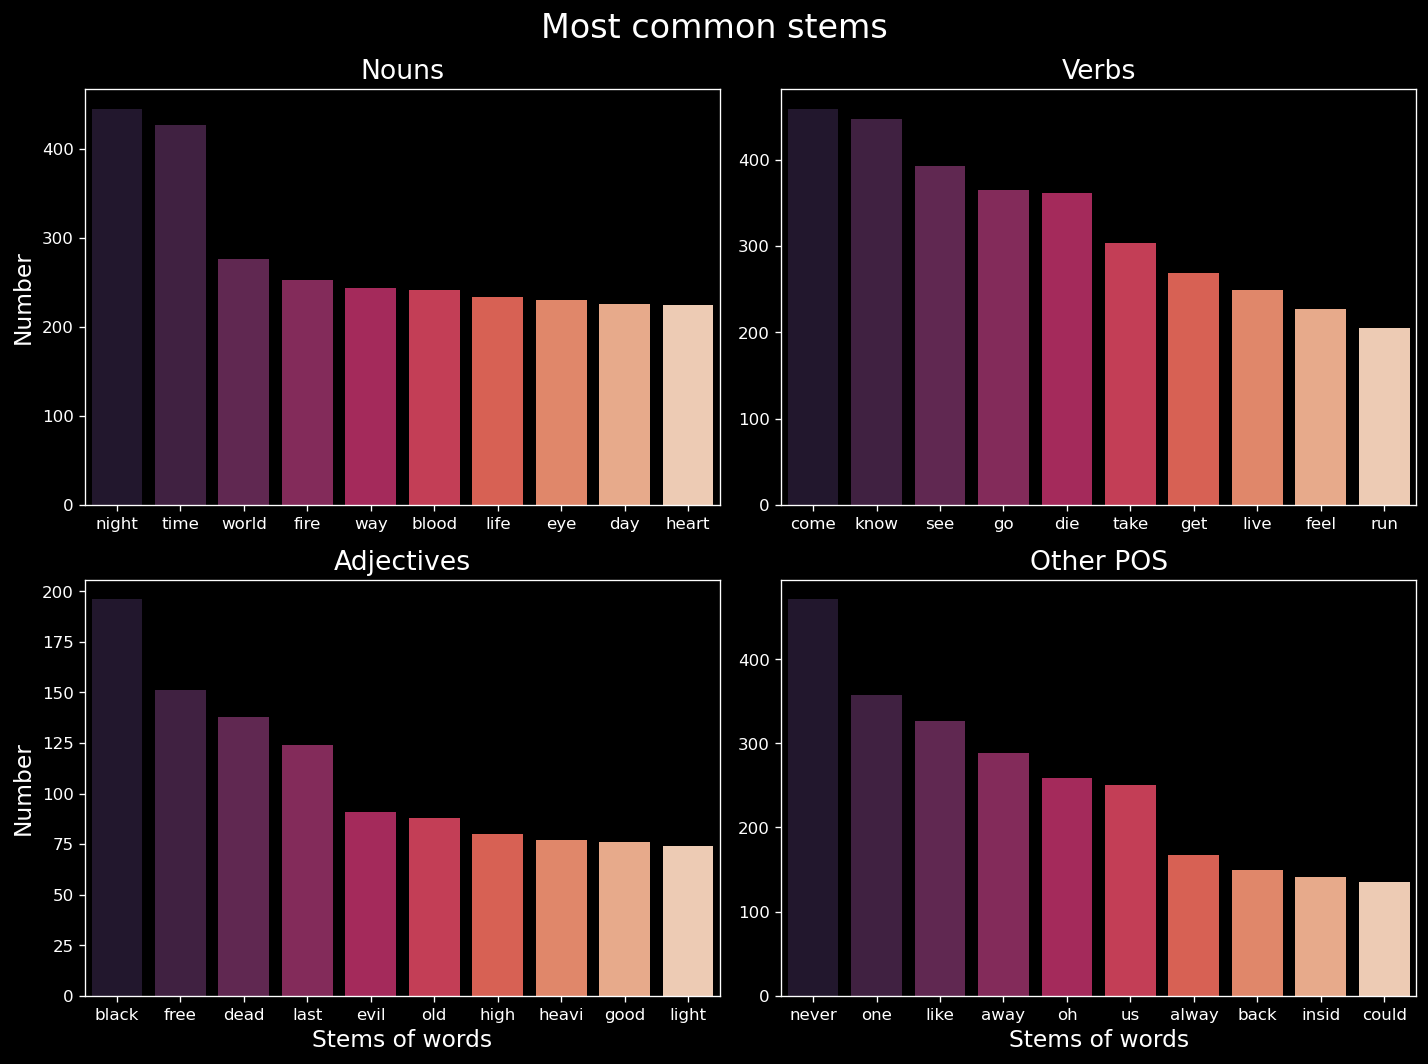

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

fig,axes = plt.subplots(2,2,figsize=(12,9),dpi=120)
fig.suptitle('Most common stems',fontsize=20)

sns.barplot(ax=axes[0][0],data=most_used_nouns[:10],x='stem',y='as_noun',palette="rocket")
axes[0][0].set_title('Nouns',fontsize=16)
axes[0][0].set_xlabel(None)
axes[0][0].set_ylabel('Number',fontsize=14)


sns.barplot(ax=axes[0][1],data=most_used_verbs[:10],x='stem',y='as_verb',palette="rocket")
axes[0][1].set_title('Verbs',fontsize=16)
axes[0][1].set_xlabel(None)
axes[0][1].set_ylabel(None)

sns.barplot(ax=axes[1][0],data=most_used_ajct[:10],x='stem',y='as_ajct',palette="rocket")
axes[1][0].set_title('Adjectives',fontsize=16)
axes[1][0].set_xlabel('Stems of words',fontsize=14)
axes[1][0].set_ylabel('Number',fontsize=14)

sns.barplot(ax=axes[1][1],data=etc[:10],x='stem',y='as_other',palette="rocket")
axes[1][1].set_title('Other POS',fontsize=16)
axes[1][1].set_xlabel('Stems of words',fontsize=14)
axes[1][1].set_ylabel(None)

fig.tight_layout()

Картина наиболее распростараненных слов по всем группам после всех произведенных манипуляций наконец приняла вполне реалистичный вид. Night и time остались фаворитами среди существительных, к ним прибавились world, fire, way и blood, что вполне соответствовало воинственному характеру песен большей части рассматриваемых групп. В пятерку наиболее распространенных глаголов вошли come, know, see и go, вполне характерные для любого английского текста, однако туда же затесался и die, что уже, определенно, можно отнести к специфике рассматриваемого материала. Глаголы be и do, которые логично было бы ожидать увидеть в данном списке, не попали в него, так как были отсеяны на стадии очистки. Прилагательные здесь показали еще большую оригинальность, поскольку в пятерке фаворитов оказалось такое не слишком распростараненное в повседневной речи слово как evil. На первом месте, впрочем, закрепилось вполне обычное слово black. 

In [41]:
def marker(row):
    r = max(list(row[['as_noun','as_ajct','as_verb','as_other']]))
    if row['as_noun'] == r:
        return 'noun'
    elif row['as_ajct'] == r:
        return 'ajct'
    elif row['as_verb'] == r:
        return 'verb'  
    else:
        return 'other'

In [42]:
for band in bands:
    base = stem_data[band]
    base['most_pop_as'] = base.apply(marker,axis=1)
    stem_data[band] = base

In [43]:
complete['most_pop_as'] = complete.apply(marker,axis=1)

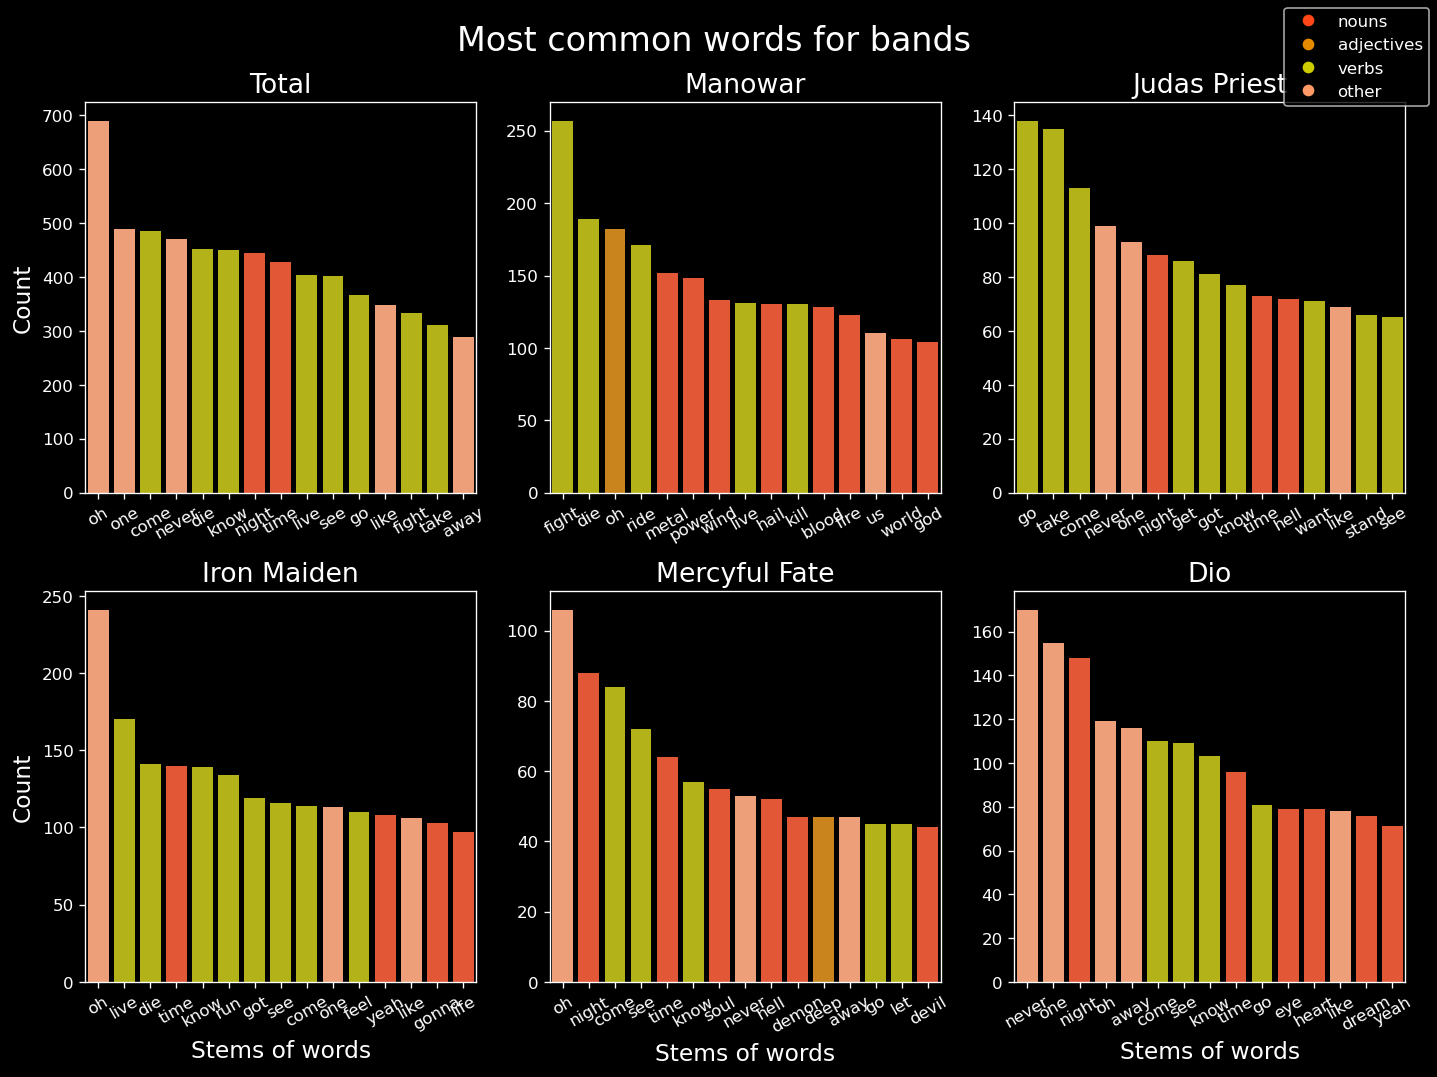

In [47]:
import itertools
fig,axes = plt.subplots(2,3,figsize=(12,9),dpi=120)
fig.suptitle('Most common words for bands',fontsize=20)

color_plan = {'nouns':'#ff471a','adjectives':'#e68a00','verbs':'#cccc00','other':'#ff9966'}


colors_1 = ['#ff9966','#cccc00','#ff471a']
sns.barplot(ax=axes[0][0],data=complete[:15],x='stem',y='count',hue='most_pop_as',palette=colors_1,dodge=False)
axes[0][0].set_title('Total',fontsize=16)
axes[0][0].set_xticklabels(labels=complete['stem'][:15],rotation = 30,fontsize=10)
axes[0][0].set_xlabel(None)
axes[0][0].set_ylabel('Count',fontsize=14)
axes[0][0].legend().set_visible(False)

colors_2 = ['#cccc00','#e68a00','#ff471a','#ff9966']
sns.barplot(ax=axes[0][1],data=stem_data['manowar'][:15],x='stem',y='count',hue='most_pop_as',palette=colors_2,dodge=False)
axes[0][1].set_title('Manowar',fontsize=16)
axes[0][1].set_xticklabels(labels=stem_data['manowar']['stem'][:15],rotation = 30,fontsize=10)
axes[0][1].set_xlabel(None)
axes[0][1].set_ylabel(None)
axes[0][1].legend().set_visible(False)

colors_3 = ['#cccc00','#ff9966','#ff471a']
sns.barplot(ax=axes[0][2],data=stem_data['judas_priest'][:15],x='stem',y='count',hue='most_pop_as',palette=colors_3,dodge=False)
axes[0][2].set_title('Judas Priest',fontsize=16)
axes[0][2].set_xticklabels(labels=stem_data['judas_priest']['stem'][:15],rotation = 30,fontsize=10)
axes[0][2].set_xlabel(None)
axes[0][2].set_ylabel(None)
axes[0][2].legend().set_visible(False)

colors_4 = ['#ff9966','#cccc00','#ff471a']
sns.barplot(ax=axes[1][0],data=stem_data['iron_maiden'][:15],x='stem',y='count',hue='most_pop_as',palette=colors_4,dodge=False)
axes[1][0].set_title('Iron Maiden',fontsize=16)
axes[1][0].set_xticklabels(labels=stem_data['iron_maiden']['stem'][:15],rotation = 30,fontsize=10)
axes[1][0].set_ylabel('Count',fontsize=14)
axes[1][0].set_xlabel('Stems of words',fontsize=14)
axes[1][0].legend().set_visible(False)

colors_5 = ['#ff9966','#ff471a','#cccc00','#e68a00']
sns.barplot(ax=axes[1][1],data=stem_data['mercyful_fate'][:15],x='stem',y='count',hue='most_pop_as',palette=colors_5,dodge=False)
axes[1][1].set_title('Mercyful Fate',fontsize=16)
axes[1][1].set_xticklabels(labels=stem_data['mercyful_fate']['stem'][:15],rotation = 30,fontsize=10)
axes[1][1].set_ylabel(None)
axes[1][1].set_xlabel('Stems of words',fontsize=14)
axes[1][1].legend().set_visible(False)

colors_6 = ['#ff9966','#ff471a','#cccc00']
sns.barplot(ax=axes[1][2],data=stem_data['dio'][:15],x='stem',y='count',hue='most_pop_as',palette=colors_6,dodge=False)
axes[1][2].set_title('Dio',fontsize=16)
axes[1][2].set_xticklabels(labels=stem_data['dio']['stem'][:15],rotation = 30,fontsize=10)
axes[1][2].set_ylabel(None)
axes[1][2].set_xlabel('Stems of words',fontsize=14)
axes[1][2].legend().set_visible(False)


m = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_plan.values()]
fig.legend(m, color_plan.keys(), numpoints=1,loc=1)


fig.tight_layout()

Картина по отдельным группам вышла достаточно разнообразной. Получилось проследить интересную тенденцию, что наиболее часто встречаемые слова у таких групп как Judas Priest или Iron Maiden - это глаголы, а у Manowar - существительные. Причем набор этих существительных у Manowar заметно отличается от наборов всех прочих групп. Также характерна любовь Mercyful Fate и Iron Maiden к междометию Oh, которое с хорошим отрывом опередило у них все прочие слова. Другой интересный факт заключается в том, что среди топ-15 слов у каждой группы практически не встречалось прилагательных. Единственным реальным исключением является слово deep у Mercyful Fate. По глаголам картина у всех кроме Manowar оказалась достаточно близкой к эталонной с минимальными отклонениями.

In [45]:
band_pos_dicts = []
for band in range(len(bands)):
    d = {
        'nouns' : 0,
        'adjectives' : 0,
        'verbs' : 0,
        'prepositions' : 0,
        'other' : 0
    }
    pos_distribution(source=dist_libs[band],dictry=d)
    band_pos_dicts.append(d)

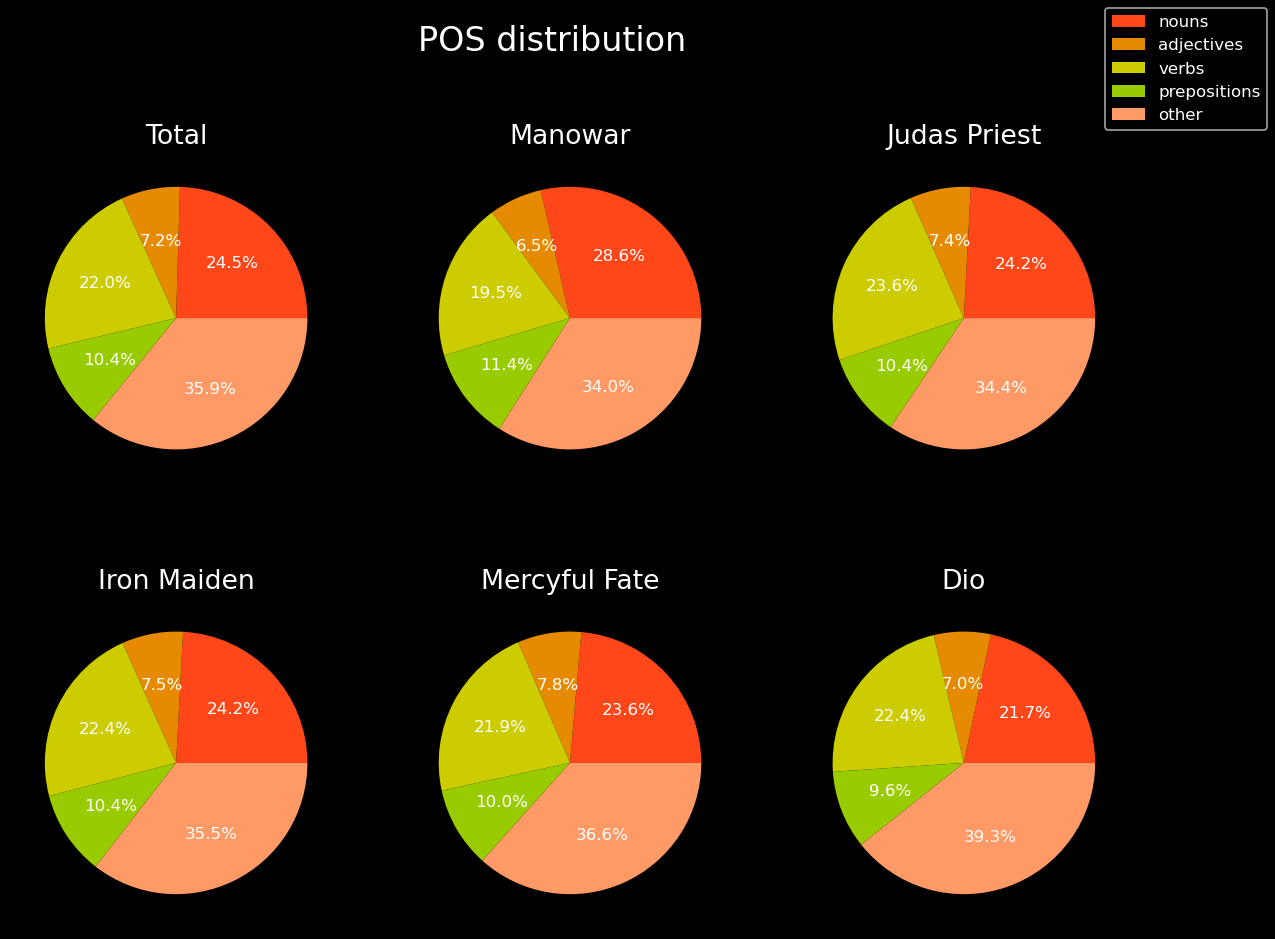

In [46]:
fig,axes = plt.subplots(2,3,figsize=(12,9),dpi=120)
fig.suptitle('POS distribution',fontsize=20)
colors = ['#ff471a','#e68a00','#cccc00','#99cc00','#ff9966']

names = list(pos_full.keys())
values = list(pos_full.values())
axes[0][0].pie(x=values,labels=None,autopct='%1.1f%%',textprops={'fontsize': 10},colors=colors)
axes[0][0].set_title('Total',fontsize=16)

names = list(band_pos_dicts[0].keys())
values = list(band_pos_dicts[0].values())
axes[0][1].pie(x=values,labels=None,autopct='%1.1f%%',textprops={'fontsize': 10},colors=colors)
axes[0][1].set_title('Manowar',fontsize=16)

names = list(band_pos_dicts[1].keys())
values = list(band_pos_dicts[1].values())
axes[0][2].pie(x=values,labels=None,autopct='%1.1f%%',textprops={'fontsize': 10},colors=colors)
axes[0][2].set_title('Judas Priest',fontsize=16)

names = list(band_pos_dicts[2].keys())
values = list(band_pos_dicts[2].values())
axes[1][0].pie(x=values,labels=None,autopct='%1.1f%%',textprops={'fontsize': 10},colors=colors)
axes[1][0].set_title('Iron Maiden',fontsize=16)

names = list(band_pos_dicts[3].keys())
values = list(band_pos_dicts[3].values())
axes[1][1].pie(x=values,labels=None,autopct='%1.1f%%',textprops={'fontsize': 10},colors=colors)
axes[1][1].set_title('Mercyful Fate',fontsize=16)

names = list(band_pos_dicts[4].keys())
values = list(band_pos_dicts[4].values())
axes[1][2].pie(x=values,labels=None,autopct='%1.1f%%',textprops={'fontsize': 10},colors=colors)
axes[1][2].set_title('Dio',fontsize=16)

fig.legend(loc=1,labels=names)



plt.show()

Картина распределения плотности частей речи по группам оказалась на удивление ровной. Отклонения в одну и в другую сторону ограничивались долями процента. Наибольшее отклонение в сторону превалирования существительных показал Manowar. У него же, по совпадению, оказалось меньше всего прилагательных. В целом же, настолько высокую схожесть структуры текстов у разных групп, можно назвать одним из наиболее значимых результатов исследования.

**Вывод:** главными целями исследования были структуризация большого количества данных из хаотичных текстов, приведение их к единой системе и поиск в этой системе существующих закономерностей. Все вышеперечисленное было успешно исполнено, а картина результатов была наглядно представлена в виде графиков. Безусловно, на этом поприще существует еще огромное количество потенциальных неотвеченных вопросов, которые также стоят рассмотрения, поэтому не исключено, что данный мини-проект в дальнейшем еще получит свое продолжение. 